# MACS 30200
### PS 2
#### Jiang Wang

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as sts
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

### Problem. 1a)

In [2]:
bq_data = np.loadtxt('BQmat_orig.txt', delimiter=',')
age_vec = np.arange(18, 96)
income_vec = np.arange(1,8)
lambdas = np.array([0.25, 0.25, 0.20, 0.10, 0.10, 0.09, 0.01])
lambdas_mdpts = np.array([0.125, 0.375, 0.60, 0.75, 0.85,
                          0.94, 0.995])
income_mat, age_mat = np.meshgrid(income_vec, age_vec)

<IPython.core.display.Javascript object>


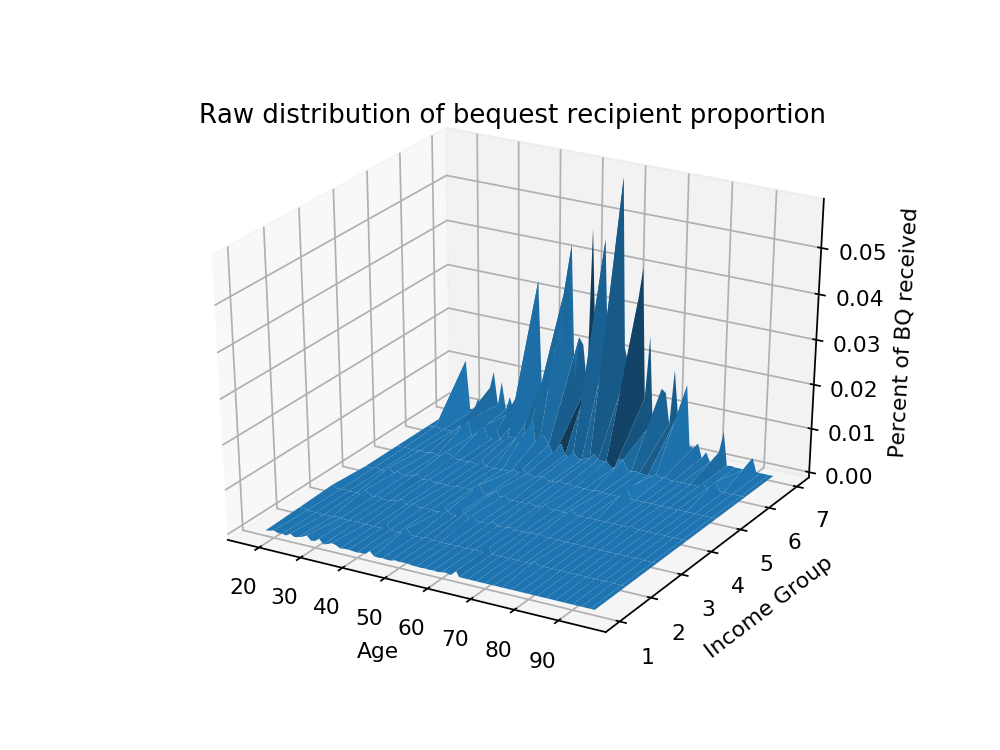

In [3]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(age_mat, income_mat, bq_data)
ax.set_title('Raw distribution of bequest recipient proportion')
ax.set_xlabel('Age')
ax.set_ylabel('Income Group')
ax.set_zlabel('Percent of BQ received')

### Problem. 1b)

In [4]:
age_vec = np.arange(18, 96)
#prcntl = np.array([0.25, 0.25, 0.20, 0.10, 0.10, 0.09, 0.01])
prcntl_mdpts = np.array([0.125, 0.375, 0.60, 0.75, 0.85, 0.94, 0.995])
income_matrix, age_matrix = np.meshgrid(prcntl_mdpts, age_vec)

In [5]:
from scipy.stats import gaussian_kde

bandwidth = 0.1

prop_mat_inc = np.sum(bq_data, axis=0)
prop_mat_age = np.sum(bq_data, axis=1)
lrg_samp = 70000
age_probs = np.random.multinomial(lrg_samp, prop_mat_age)
income_probs = np.random.multinomial(lrg_samp, prop_mat_inc)
age_freq = np.array([])
inc_freq = np.array([])

# creating a distribution of age values
for age, num_s in zip(age_vec, age_probs):
    vec_age_s = np.ones(num_s)
    vec_age_s *= age
    age_freq = np.append(age_freq, vec_age_s)

# creating a distribution of income levels
for abil, num_j in zip(lambdas_mdpts, income_probs):
    vec_abil_j = np.ones(num_j)
    vec_abil_j *= abil
    inc_freq = np.append(inc_freq, vec_abil_j)

data = np.vstack((age_freq, inc_freq))
kernel = gaussian_kde(data, bw_method=bandwidth)

income_mat, ages_mat = np.meshgrid(income_vec, age_vec)

In [6]:
coords = np.vstack([item.ravel() for item in [age_matrix, income_matrix]])
BQkde = kernel(coords).reshape(age_matrix.shape)
BQkde_scaled = BQkde / BQkde.sum()

<IPython.core.display.Javascript object>


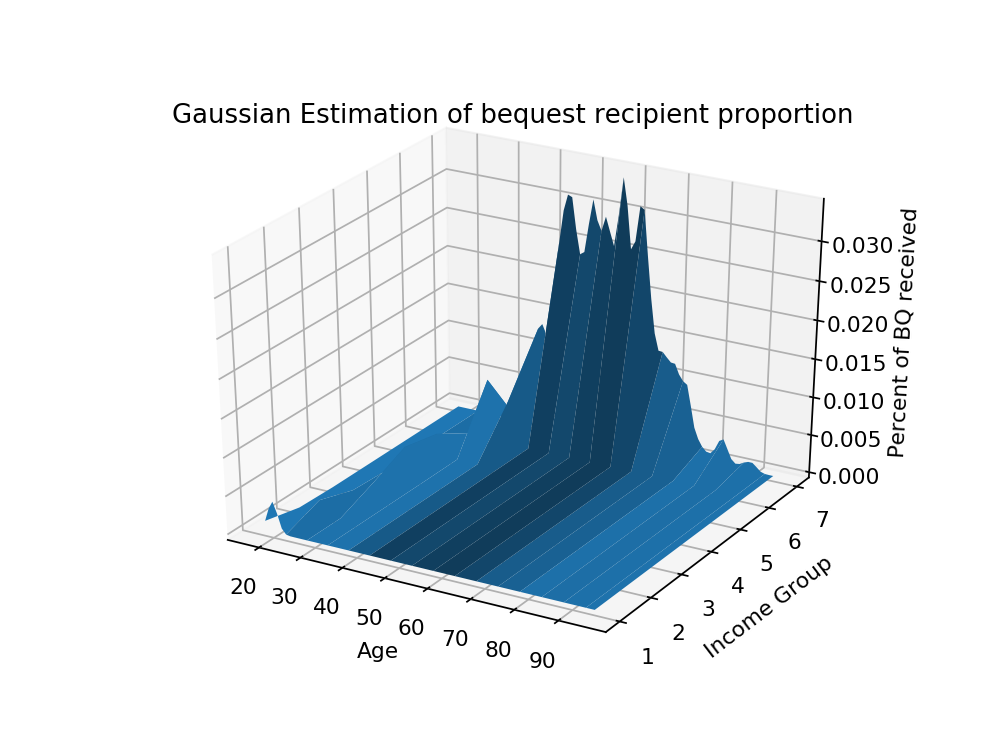

In [7]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(age_matrix, income_mat, BQkde_scaled, rstride =5)
ax.set_title('Gaussian Estimation of bequest recipient proportion')
ax.set_xlabel('Age')
ax.set_ylabel('Income Group')
ax.set_zlabel('Percent of BQ received')
plt.show()

In [8]:
est_density = BQkde_scaled[61-18+1,5]
print(" The estimated density for a person aged 61 who lies between the 90th and 99th percentile is:\n", est_density)

 The estimated density for a person aged 61 who lies between the 90th and 99th percentile is:
 9.75514337191e-07


## Interaction Terms

In [9]:
import statsmodels.formula.api as smf

biden = pd.read_csv('biden.csv', sep = ',').dropna(axis=0, how='any')

In [10]:
model = smf.ols('biden ~ age + educ + age*educ', data=biden).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  biden   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     10.74
Date:                Sun, 29 Apr 2018   Prob (F-statistic):           5.37e-07
Time:                        23:06:41   Log-Likelihood:                -8249.3
No. Observations:                1807   AIC:                         1.651e+04
Df Residuals:                    1803   BIC:                         1.653e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     38.3735      9.564      4.012      0.0

The marginal effect of `age` on `biden` is $0.6719 - 0.0480educ$, 

If `educ` = 0, then the effect of `age` is 0.6719.

If `educ` = $\frac{0.6719}{0.0480} \approx 14$, then `age` would have no effect on `biden`. `age` would have a positive effect on biden when `educ` < 14, and a negative effect when `educ` > 14. The wald test below yields a p-value of $0.804 \cdot 10^{-05}$, providing sufficient evidence against the null hypothesis that the variable `age` has no marginal effect.

In [11]:
print(model.wald_test('age + age:educ').summary())

<F test: F=array([[ 15.61971126]]), p=8.043107684541717e-05, df_denom=1803, df_num=1>


The marginal effect of `educ` on `biden` is $1.6574 - 0.0480age$, 

If `age` = 0, then the effect of `educ` is 1.6574.

If `age` = $\frac{1.6574}{0.0480} \approx 35$, then `educ` would have no effect on `biden`. `educ` would have a positive effect on biden when `age` < 35, and a negative effect when `age` > 35. The wald test below yields a p-value of $0.022$, providing sufficient evidence against the null hypothesis that the variable `educ` has no marginal effect.

In [12]:
print(model.wald_test('educ + age:educ').summary())

<F test: F=array([[ 5.25945763]]), p=0.02194241268853349, df_denom=1803, df_num=1>


## Parallel computing versus serial computing a bootstrapped cross validation (bonus).

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
import time
import statsmodels.api as sm
import dask

auto = pd.read_csv('Auto.csv', na_values='?').dropna(how='any').drop(['name'], axis=1)
auto['mpg_high'] = auto['mpg'].apply(lambda x: int(x>=auto['mpg'].median()))
#Set Variables
Y = auto['mpg_high']
X = sm.add_constant(auto[['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'year', 'origin']])

C:\Users\Jiang\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\Jiang\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [14]:
def timer(func):
    from time import time
    def inner(*args):
        start = time()
        a = func()
        end = time()
        print('\nTime elapsed =', end-start, 'seconds')
        return a
    return inner

In [15]:
@timer
def serial():
    N_bs = 100
    lazy_values = []

    for bs_ind in range(N_bs):
        np.random.seed(seed=bs_ind)
        X_train, X_test, y_train, y_test = \
            train_test_split(X, Y, test_size=0.35)
        LogReg = LogisticRegression()
        LogReg.fit(X_train, y_train)
        y_pred = LogReg.predict(X_test)
        lazy_values.append(((y_test - y_pred) ** 2).mean())
    
    lazy_values = np.array(lazy_values)
    MSE_bs = lazy_values.mean()
    MSE_bs_std = lazy_values.std()
    print('Test estimate MSE bootstrap = ', MSE_bs,
          '\nTest estimate MSE standard err = ', MSE_bs_std)

In [16]:
from dask import compute, delayed
import dask.multiprocessing
import dask.threaded

def bootstrap(bs_ind, X, Y):
    np.random.seed(seed=bs_ind)
    X_train, X_test, y_train, y_test = \
        train_test_split(X, Y, test_size=0.35)
    LogReg = LogisticRegression()
    LogReg.fit(X_train, y_train)
    y_pred = LogReg.predict(X_test)
    return ((y_test - y_pred) ** 2).mean()

lazy_values = []

for bs_ind in range(100):
    lazy_values.append(delayed(bootstrap)(bs_ind, X, Y))

In [17]:
@timer
def parallel():
    lazy_values = []
    for bs_ind in range(100):
        lazy_values.append(delayed(bootstrap)(bs_ind, X, Y))

    results_par = compute(*lazy_values, get=dask.threaded.get, num_workers=3)
    MSE_vec_bs = np.array(results_par)
    MSE_bs = MSE_vec_bs.mean()
    MSE_bs_std = MSE_vec_bs.std()
    print('Test estimate MSE bootstrap = ', MSE_bs,
          '\nTest estimate MSE standard err = ', MSE_bs_std)

In [18]:
serial()

Test estimate MSE bootstrap =  0.101376811594 
Test estimate MSE standard err =  0.021262776161

Time elapsed = 0.321242094039917 seconds


In [19]:
parallel()

Test estimate MSE bootstrap =  0.101666666667 
Test estimate MSE standard err =  0.0213357502963

Time elapsed = 0.2810547351837158 seconds
